# import library

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_turnbackhoax_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_cnn_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_kompas_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_tempo_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_turnbackhoax_10_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_cnn_10k_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_kompas_4k_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_tempo_6k_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/RAW/dataset_kompas_4k.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/RAW/dataset_turnbackhoax_10k.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/RAW/dataset_temp

In [64]:
import pandas as pd
import numpy as np
import os
import torch
import string
import re
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, Trainer, TrainingArguments

from datasets import Dataset, concatenate_datasets, DatasetDict, load_metric

from sklearn.metrics import ConfusionMatrixDisplay

In [65]:
cnn = '/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_cnn_10k_cleaned.xlsx'
kompas = '/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_kompas_4k_cleaned.xlsx'
hoax = '/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_turnbackhoax_10_cleaned.xlsx'

In [66]:
def excel_to_df(excel):
    df = pd.read_excel(excel, index_col=0)
    # df = df.drop(columns=df.columns[0])
    return df

df_cnn = excel_to_df(cnn)
df_kompas = excel_to_df(kompas)
df_hoax = excel_to_df(hoax)

In [67]:
print("Shape of cnn data: {}".format(df_cnn.shape))
print("Shape of kompas data: {}".format(df_kompas.shape))
print("Shape of hoax data: {}".format(df_hoax.shape))

Shape of cnn data: (9630, 8)
Shape of kompas data: (4750, 8)
Shape of hoax data: (10381, 10)


In [68]:
df_cnn.head(2)

,Title,Timestamp,FullText,Tags,Author,Url,text_new,hoax
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,"Selasa, 21 Feb 2023 21:22 WIB","Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",anies baswedan;pengajian;pilpres 2024;badan ko...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,"Selasa, 21 Feb 2023 20:46 WIB","Medan, CNN Indonesia -- Gubernur Sumatera Utar...",edy rahmayadi;pemilu 2024;pilkada 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0


In [69]:
df_kompas.head(2)

,Title,Timestamp,FullText,Tags,Author,Url,text_new,hoax
0,"Efek Ekor Jas Pencalonan Anies, Elektabilitas ...","21 Februari 2023, 15:30 WIB",Hasil jajak pendapat yang diselenggarakan Litb...,Survei Litbang Kompas;Elektabilitas Nasdem Nai...,NaN,https://video.kompas.com/watch/258152/efek-eko...,"Efek Ekor Jas Pencalonan Anies, Elektabilitas ...",0
1,"Ekonomi 2024 Ditargetkan Tumbuh 5,7 Persen, pa...","Kompas.com - 21/02/2023, 14:22 WIB","JAKARTA, KOMPAS.com - Pemerintah menargetkan p...",Jakarta;Ekonomi 2024,Penulis Yohana Artha Uly | Editor Aprillia Ika,http://money.kompas.com/read/2023/02/21/142238...,"Ekonomi 2024 Ditargetkan Tumbuh 5,7 Persen, pa...",0


In [70]:
df_hoax.head(2)

,Title,Timestamp,FullText,Tags,Author,Url,politik,Narasi,Clean Narasi,hoax
0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-anies...,1,\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU...,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1
1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-hakim...,0,\n“ini bener gasih?? Ya Allah gimna keadaan pa...,ini bener gasih?? Ya Allah gimna keadaan pa ha...,1


In [71]:
df_cnn = df_cnn[['text_new','hoax']]
df_kompas = df_kompas[['text_new','hoax']]
df_hoax = df_hoax[['Clean Narasi','hoax']]

df_cnn = df_cnn.rename(columns = {'text_new':'text'})
df_kompas = df_kompas.rename(columns = {'text_new':'text'})
df_hoax = df_hoax.rename(columns = {'Clean Narasi':'text'})

df = pd.concat([df_cnn, df_kompas, df_hoax])
df

,text,hoax
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
10379,Raja Salman dari arab saudi membawa orang-oran...,1
10380,"hehe, selalu bisa tersenyum melihat tingkah la...",1
10381,Pak Jokowi itu menjadi walikota periode pertam...,1
10382,"Hari ini, Rabu (23/09/2015), nilai tukar rupia...",1


In [72]:
print(len(df))

24761


In [73]:
df['hoax'].value_counts()

hoax
0    14380
1    10381
Name: count, dtype: int64

# Data Analysis

In [74]:
df.isna().sum()

text    3906
hoax       0
dtype: int64

In [75]:
# Drop missing value
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [76]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,text,hoax,word_count
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,263
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,281
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,183
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,185
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,200


In [77]:
df['num_char'] = df['text'].apply(lambda x: len(x))
df.head()

,text,hoax,word_count,num_char
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,263,1955
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,281,1927
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,183,1301
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,185,1327
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,200,1467


In [78]:
#Stopwords
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


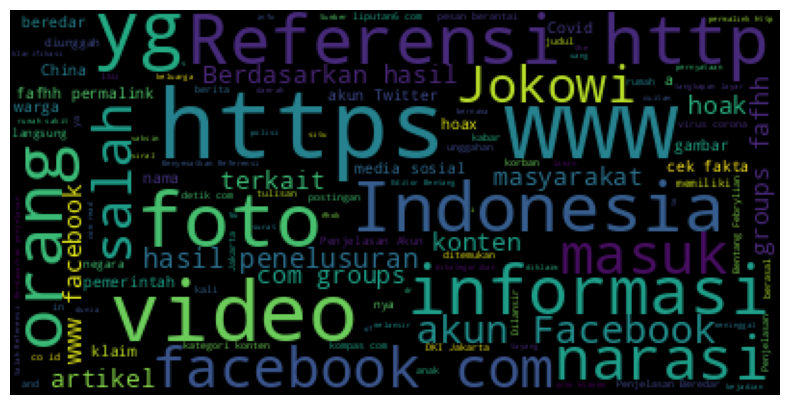

In [79]:
# label 1 untuk hoax
import wordcloud
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(max_font_size=50, background_color="black",
            stopwords=stop_words)

cloud1 = wordcloud.generate(df.loc[df.hoax==1, 'text'].str.cat(sep='\n'))

plt.figure(figsize=(10,5))
plt.imshow(cloud1)
plt.axis("off")
plt.show()

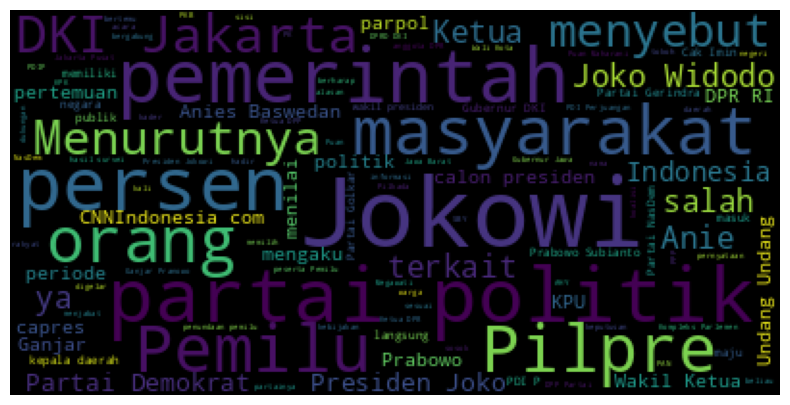

In [80]:
#label 0 atau valid
cloud0 = wordcloud.generate(df.loc[df.hoax==0, 'text'].str.cat(sep='\n'))

plt.figure(figsize=(10,5))
plt.imshow(cloud0)
plt.axis("off")
plt.show()

# Data Preprocessing

## Data Cleaning

In [81]:
df.iloc[4,0]

'PKN Siapkan Jabatan Khusus Buat Anas Urbaningrum Usai Bebas April  Dewan Pimpinan Pusat (DPP) Partai Kebangkitan Nusantara (PKN) menyiapkan jabatan khusus untuk Anas Urbaningrum\xa0usai bebas dari penjara pada pada April mendatang. Ketua Umum PKN I Gede Pasek Suardika mengatakan Anas akan menduduki jabatan khusus bersama Laksamana Sukardi yang baru saja menjadi kader. "Kita berharap Mas Anas dan Pak Laks [Laksamana Sukardi] nanti di dalam satu jabatan khusus," kata Pasek di kantor pusat PKN, Menteng, Jakarta Pusat, Selasa (21/1).                   Pasek belum menyebutkan secara gamblang apa jabatan khusus tang dimaksud. Dia hanya mengatakan posisi itu penentu arah perjuangan partai. Menurut Pasek, Anas dan Sukardi memiliki kesamaan sebagai tokoh yang sama-sama pernah dikriminalisasi. Namun, Anas dinilai hanya kurang beruntung karena langsung berhadapan dengan penguasa\xa0kala itu. "Bedanya beliau [Sukardi] mampu tegar teguh melawan, sehingga selamat. Sementara Mas Anas karena mungkin 

In [82]:
df.isna().sum()

text          0
hoax          0
word_count    0
num_char      0
dtype: int64

## Text preprocessing

In [83]:
df.iloc[250,0]

'Ketua Komisi II: Usul Hapus Jabatan Gubernur Harus Lewat Amendemen UUD  Ketua Komisi II\xa0DPR Ahmad Doli Kurnia mengatakan usulan menghapus jabatan gubernur harus dilakukan melalui amandemen UUD 1945.Doli menjelaskan posisi gubernur dalam tata pemerintahan Indonesia telah diatur dalam UUD. Artinya, wacana menghapus jabatan gubernur tidak hanya melalui revisi undang-undang saja."Bukan hanya perubahan undang-undang biasa, tetapi juga UUD 1945, karena posisi gubernur itu diatur dalam UUD 1945. Artinya ada amendemen," ucap Doli di kantor DPP Golkar, Selasa (7/2).        Menurut Doli, posisi gubernur sudah ada sejak Indonesia merdeka dan menjadi kepanjangan tangan pemerintah pusat di daerah.Ia berpendapat peran gubernur selama ini cukup baik dalam koordinasi pembangunan di daerah."Jadi saya kira belum ada urgensinya, belum ketemu urgensinya kita mengkaji posisi gubernur," kata dia.Di samping itu, politikus Partai Golkar itu mempertanyakan seberapa penting mengakomodasi wacana itu dengan a

In [84]:
# removing breaking space
def remove_breaking_space(text):
  return text.replace('\xa0', ' ')

# removing spaces that appear more than once
def remove_unused_space(text):
  return re.sub(' +', ' ', text)

# remove text inside parentheses
def remove_parentheses(text):
  return re.sub("[\(\[].*?[\)\]]", "", text)

# turn text to lowercases
def lowercasing(text):
  return text.lower()

# give space for punctuation
def punctuation_spacing(text):
  for punct in string.punctuation:
    text = text.replace(punct, f' {punct} ')

  return re.sub(' +', ' ', text)

df['text'] = df['text'].map(lambda x: remove_breaking_space(x))
df['text'] = df['text'].map(lambda x: remove_unused_space(x))
df['text'] = df['text'].map(lambda x: remove_parentheses(x))
df['text'] = df['text'].map(lambda x: lowercasing(x))
df['text'] = df['text'].map(lambda x: punctuation_spacing(x))

In [85]:
# mengubah nama kolom
df = df.rename(columns = {'hoax':'labels'})

In [86]:
df_cnn.iloc[0,0]

'Anies di Milad BKMT: Pengajian Menghasilkan Ibu-ibu Berpengetahuan  Mantan Gubernur DKI Jakarta Anies Baswedan menghadiri acara tasyakuran Milad ke-42 tahun Badan Kontak Majelis Taklim (BKMT) di Istora Senayan, Jakarta, Selasa (21/2). Dia pun memuji eksistensi ibu-ibu pengajian mewujudkan keberhasilan pendidikan di dalam keluarga. Ia mengatakan selama 42 tahun usianya, BKMT telah menjadi teladan keberhasilan pendidikan dalam keluarga.\xa0BKMT, kata dia, menjadi bukti bahwa pengajian menghasilkan ibu-ibu yang lebih berpengetahuan.       "BKMT menjadi bukti bahwa pengajian menghasilkan ibu-ibu yang lebih berpengetahuan. Ibu-ibu yang punya bekal untuk mendidik anak-anaknya, membuat rumah yang mencerminkan nilai Islam dan akhlak yang baik," kata Anies\xa0dikutip dari unggahan\xa0akun\xa0media sosial Instagram miliknya.             Dalam unggahannya, Anies menyinggung soal BKMT yang tidak dapat dilepaskan dari sosok Tuty Alawiyah. Menurut Anies, Tuty bukan hanya seorang ustazah yang mampu 

In [87]:
df.iloc[0,0]

'anies di milad bkmt : pengajian menghasilkan ibu - ibu berpengetahuan mantan gubernur dki jakarta anies baswedan menghadiri acara tasyakuran milad ke - 42 tahun badan kontak majelis taklim di istora senayan , jakarta , selasa . dia pun memuji eksistensi ibu - ibu pengajian mewujudkan keberhasilan pendidikan di dalam keluarga . ia mengatakan selama 42 tahun usianya , bkmt telah menjadi teladan keberhasilan pendidikan dalam keluarga . bkmt , kata dia , menjadi bukti bahwa pengajian menghasilkan ibu - ibu yang lebih berpengetahuan . " bkmt menjadi bukti bahwa pengajian menghasilkan ibu - ibu yang lebih berpengetahuan . ibu - ibu yang punya bekal untuk mendidik anak - anaknya , membuat rumah yang mencerminkan nilai islam dan akhlak yang baik , " kata anies dikutip dari unggahan akun media sosial instagram miliknya . dalam unggahannya , anies menyinggung soal bkmt yang tidak dapat dilepaskan dari sosok tuty alawiyah . menurut anies , tuty bukan hanya seorang ustazah yang mampu memimpin rat

In [88]:
df = df[['text', 'labels']]
df

,text,labels
0,anies di milad bkmt : pengajian menghasilkan i...,0
1,edy soal pilgub sumut : kalau yang maju abal -...,0
2,pkb bakal daftarkan menaker ida fauziyah jadi ...,0
3,gede pasek doakan ahy jadi capres atau cawapre...,0
4,pkn siapkan jabatan khusus buat anas urbaningr...,0
...,...,...
20850,raja salman dari arab saudi membawa orang - or...,1
20851,"hehe , selalu bisa tersenyum melihat tingkah l...",1
20852,pak jokowi itu menjadi walikota periode pertam...,1
20853,"hari ini , rabu , nilai tukar rupiah terpuruk ...",1


In [89]:
# under sampling
from imblearn.under_sampling import RandomUnderSampler

X = df[['text']]
y = df['labels']
rus = RandomUnderSampler(random_state=1, replacement=False)
X_new, y_new = rus.fit_resample(X,y)

df = X_new
df['labels'] = y_new

In [90]:
ds = Dataset.from_pandas(df).train_test_split(seed=1, test_size=0.2)
ds_test_eval = ds['test'].train_test_split(seed=1, test_size=0.5)

In [91]:
ds_train = ds['train']
ds_eval = ds_test_eval['train']
ds_test = ds_test_eval['test']

In [92]:
ds_train

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 10403
})

In [93]:
ds_test

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 1301
})

# Tokenizing

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [95]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
def tokenize_dataset(data):
  # Keys of the returned dictionary will be added to the dataset as columns
  return tokenizer(data['text'], padding=True, truncation=True, max_length=512)

ds_train_ = ds_train.map(tokenize_dataset)
ds_eval_ = ds_eval.map(tokenize_dataset)
ds_test_ = ds_test.map(tokenize_dataset)

Map:   0%|          | 0/10403 [00:00<?, ? examples/s]

Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1301 [00:00<?, ? examples/s]

In [97]:
ds_train_tokenized = ds_train_.remove_columns(['text'])
ds_eval_tokenized = ds_eval_.remove_columns(['text'])
ds_test_tokenized = ds_test_.remove_columns(['text'])

ds_token = DatasetDict({
    'train': ds_train_tokenized,
    'eval':ds_eval_tokenized,
    'test': ds_test_tokenized
    }
)

ds_token

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10403
    })
    eval: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1300
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1301
    })
})

# Model Training

In [98]:
batch_size = 1
args = TrainingArguments(
    output_dir=f"IndoBERT-HoaxDetection",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [99]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [100]:
model = model.to(device)

trainer = Trainer(
    model,
    args,
    train_dataset=ds_token["train"],
    eval_dataset=ds_token["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [101]:
os.environ["WANDB_DISABLED"] = "true"
trainer.evaluate(eval_dataset=ds_token["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.9581016302108765,
 'eval_accuracy': 0.003843197540353574,
 'eval_runtime': 48.6343,
 'eval_samples_per_second': 26.751,
 'eval_steps_per_second': 13.386}

In [102]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.036000,0.046645,0.993077
2,0.000000,0.054436,0.992308
3,0.000000,0.072759,0.992308


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=15606, training_loss=0.030027087099599115, metrics={'train_runtime': 3558.3137, 'train_samples_per_second': 8.771, 'train_steps_per_second': 4.386, 'total_flos': 5742360745793550.0, 'train_loss': 0.030027087099599115, 'epoch': 3.0})

In [103]:
trainer.evaluate(eval_dataset=ds_token["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.05734122917056084,
 'eval_accuracy': 0.994619523443505,
 'eval_runtime': 49.0544,
 'eval_samples_per_second': 26.522,
 'eval_steps_per_second': 13.271,
 'epoch': 3.0}

In [105]:
trainer.save_model()

# Evaluation

In [106]:
pred_output = trainer.predict(test_dataset=ds_token['test'])

In [109]:
pred_output.metrics

{'test_loss': 0.05734122917056084,
 'test_accuracy': 0.994619523443505,
 'test_runtime': 49.7292,
 'test_samples_per_second': 26.162,
 'test_steps_per_second': 13.091}

In [110]:
pred_label = np.argmax(pred_output.predictions, axis=1)
gt_label = ds_token["test"]['labels']

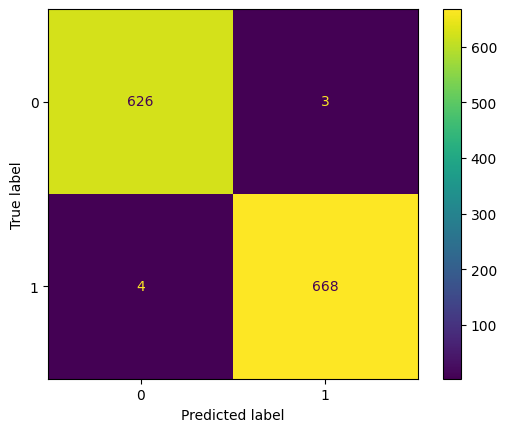

In [111]:
ConfusionMatrixDisplay.from_predictions(pred_label, ds_token['test']['labels'])

In [113]:
# take it from tokenized data instead of input
test_data = tokenizer.batch_decode(ds_token["test"]['input_ids'], skip_special_tokens=True)

# create gt and prediction comparation
pred_compare = []
for i, news in enumerate(test_data):
    pred_compare.append([news, gt_label[i], pred_label[i]])

# turn it to dataframe for easy processing
df_pred_compare = pd.DataFrame(pred_compare)
df_pred_compare = df_pred_compare.rename(columns={0:'news', 1:'labels', 2:'prediction'})
df_pred_compare.to_csv('predictions.csv')
df_pred_compare

,news,labels,prediction
0,"wooooi cebong, ini satu lagi bukti bahwa imam ...",1,1
1,"terlibat politik praktis, 21 asn di kabupaten ...",0,0
2,virus omnicron di lihat dri microscop zionist ...,1,1
3,"ramai isu capres, hasto sebut megawati cuma se...",0,0
4,only these bands will save us from corona viru...,1,1
...,...,...,...
1296,waspada!!! berita hoax yang beredar terkait un...,1,1
1297,jokowi : belum tentu capres elektabilitas ting...,0,0
1298,jokowi lantik kpu - bawaslu 2022 - 2027 hari i...,0,0
1299,informasi resmi tik - tok 2022 nomor anda terp...,1,1
